In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RELACS as rel
import matplotlib
#import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.colors as mcolors
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Perform differential motif analysis in ATAC regions associated with up- and downregulated genes and with dynamic accessibile regions between EPZ and DMSO treated NPC48h

In [3]:
### DEFINE UP- AND DOWN-REGULATED GENES ###

deg_npc = pd.read_csv("../../figure_3/INTERMEDIATE_FILES/DE_genes_shrinked_apeglm_NPC48h_EPZvsDMSO.tsv", sep="\t")
deg_npc_up = deg_npc.loc[(deg_npc.padj<0.1) & (deg_npc.log2FoldChange>0)]
deg_npc_down = deg_npc.loc[(deg_npc.padj<0.1) & (deg_npc.log2FoldChange<0)]


In [337]:
### DEFINE BACKGROUND ATAC REGIONS ###

random_atac = pd.read_csv("../INPUT_DATA/NPC48hs_MACS2_BAMPE_consensusSet.bed",sep="\t",header=None)
random_atac.sample(1000, replace=False).to_csv("../INTERMEDIATE_FILES/RandomATAC_NPC_1000.bed",sep="\t",index=False,header=False)
random_atac

,0,1,2,3
0,1,3294375,3294632,consensusPeak_1
1,1,3670651,3671028,consensusPeak_2
2,1,3671643,3672484,consensusPeak_3
3,1,3842088,3842637,consensusPeak_4
4,1,3994569,3995013,consensusPeak_5
...,...,...,...,...
32231,Y,3376521,3377022,consensusPeak_32232
32232,Y,90742307,90744873,consensusPeak_32233
32233,Y,90760313,90760598,consensusPeak_32234
32234,Y,90761217,90761817,consensusPeak_32235


In [4]:
### DEFINE PROMOTERS TO SELECT ###

prom_npc = pd.read_csv("../../figure_3/INTERMEDIATE_FILES/Promoter_Model_ChromSeg_NPC48h.bed", sep="\t", header=None,
                      names = ["chr","start","end","geneID","sc","strand","symbol","length"])
prom_npc.index = prom_npc.geneID

prom_npc_up = prom_npc.loc[deg_npc_up.index].dropna()
prom_npc_up["start"] = prom_npc_up["start"].astype('int')
prom_npc_up["end"] = prom_npc_up["end"].astype('int')
prom_npc_up.to_csv("../INTERMEDIATE_FILES/Promoter_NPC_up.bed",sep="\t",index=False,header=False)

prom_npc_down = prom_npc.loc[deg_npc_down.index].dropna()
prom_npc_down["start"] = prom_npc_down["start"].astype('int')
prom_npc_down["end"] = prom_npc_down["end"].astype('int')
prom_npc_down.to_csv("../INTERMEDIATE_FILES/Promoter_NPC_down.bed",sep="\t",index=False,header=False)

prom_npc.sample(1000, replace=False).to_csv("../INTERMEDIATE_FILES/Promoter_NPC_Background_1000.bed",sep="\t",index=False,header=False)


/package/anaconda3/bin/ipython:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  from IPython import start_ipython
/package/anaconda3/bin/ipython:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


In [5]:
%%bash

### INTERSECT ATAC PEAKS WITH PROMOTERS OF DEG GENES AND DEFINE DET OF DYNAMIC ATAC REGIONS ###

bedtools intersect -a ../INPUT_DATA/NPC48hs_MACS2_BAMPE_consensusSet.bed -b ../INTERMEDIATE_FILES/Promoter_NPC_up.bed -u > ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC.bed
bedtools intersect -a ../INPUT_DATA/NPC48hs_MACS2_BAMPE_consensusSet.bed -b ../INTERMEDIATE_FILES/Promoter_NPC_down.bed -u > ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC.bed
bedtools intersect -a ../INPUT_DATA/NPC48hs_MACS2_BAMPE_consensusSet.bed -b ../INTERMEDIATE_FILES/Promoter_NPC_Background.bed -u > ../INTERMEDIATE_FILES/ATAC_onBackground_NPC.bed

awk -v OFS="\t" '{printf "%s:%d-%d\tup\n",$1,($2+(($3-$2)/2))-500,($2+(($3-$2)/2))+500}' ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC_1kbExt.txt
awk -v OFS="\t" '{printf "%s:%d-%d\tdown\n",$1,($2+(($3-$2)/2))-500,($2+(($3-$2)/2))+500}' ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC_1kbExt.txt
awk -v OFS="\t" '{printf "%s:%d-%d\tback\n",$1,($2+(($3-$2)/2))-500,($2+(($3-$2)/2))+500}' ../INTERMEDIATE_FILES/ATAC_onBackground_NPC.bed > ../INTERMEDIATE_FILES/ATAC_onBackground_NPC_1kbExt.txt
awk -v OFS="\t" '{printf "%s:%d-%d\tatacDown\n",$1,$2,$3}' ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE_Ext.bed > ../INTERMEDIATE_FILES/ATAC_Down_NPC_1kbExt.txt
awk -v OFS="\t" '{printf "%s:%d-%d\tatacUP\n",$1,$2,$3}' ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE_Ext.bed > ../INTERMEDIATE_FILES/ATAC_UP_NPC_1kbExt.txt



cat ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC_1kbExt.txt ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC_1kbExt.txt ../INTERMEDIATE_FILES/ATAC_onBackground_NPC_1kbExt.txt | sort | uniq > ../INTERMEDIATE_FILES/input_mealstrom.txt
cat ../INTERMEDIATE_FILES/input_mealstrom.txt | uniq -w 15 -u > ../INTERMEDIATE_FILES/input_mealstrom_def.txt
awk 'BEGIN{print "loc","cluster"}{print $0}' ../INTERMEDIATE_FILES/input_mealstrom_def.txt > ../INTERMEDIATE_FILES/input_mealstrom_def_def.txt

cat ../INTERMEDIATE_FILES/ATAC_Down_NPC_1kbExt.txt ../INTERMEDIATE_FILES/ATAC_UP_NPC_1kbExt.txt | sort | uniq > ../INTERMEDIATE_FILES/input_mealstrom_diffAtac.txt
cat ../INTERMEDIATE_FILES/input_mealstrom_diffAtac.txt | uniq -w 15 -u > ../INTERMEDIATE_FILES/input_mealstrom_diffAtac_def.txt
awk 'BEGIN{print "loc","cluster"}{print $0}' ../INTERMEDIATE_FILES/input_mealstrom_diffAtac_def.txt > ../INTERMEDIATE_FILES/input_mealstrom_diffAtac_def_def.txt



In [50]:
%%bash

### RUN DIFFERENTIAL MOTIF ANALYSIS FOR DYNAMIC ATAC REGIONS ###

source activate gimme

gimme maelstrom ../INTERMEDIATE_FILES/input_mealstrom_diffAtac_def_def.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_enh



/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [174]:
%%bash

### RUN DIFFERNTIAL MOTIF ANALYSIS FOR ATAC PEAKS OVERLAPPING DEG PROMOTERS ###

source activate gimme

gimme maelstrom ../INTERMEDIATE_FILES/input_mealstrom_def_def.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_1_1
gimme maelstrom ../INTERMEDIATE_FILES/input_mealstrom_def_def.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_2_1
gimme maelstrom ../INTERMEDIATE_FILES/input_mealstrom_def_def.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_3_1
gimme maelstrom ../INTERMEDIATE_FILES/input_mealstrom_def_def.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_4_1
gimme maelstrom ../INTERMEDIATE_FILES/input_mealstrom_def_def.txt /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_5_1




/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

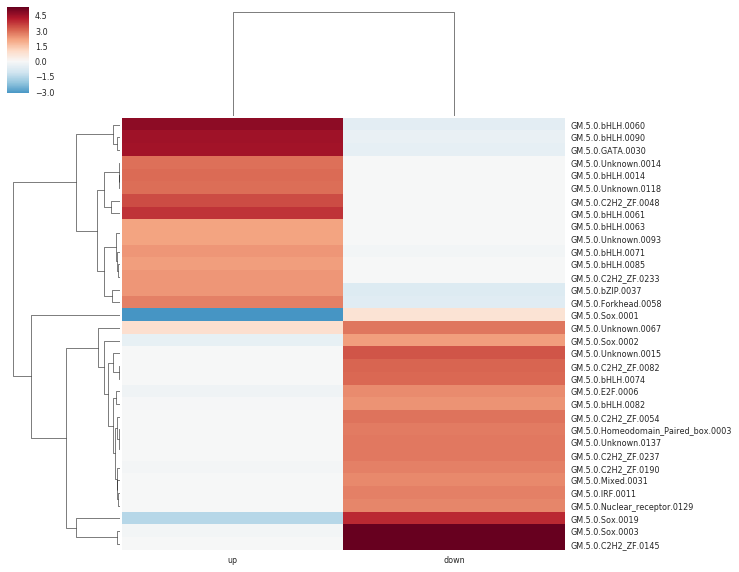

In [7]:
### AVERAGE RESULTS OVER 5 DIFFERENT RUNS ###

res_1 = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_1_1/final.out.csv", index_col=0)
res_2= pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_2_1/final.out.csv", index_col=0)
res_3 = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_3_1/final.out.csv", index_col=0)
res_4 = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_4_1/final.out.csv", index_col=0)
res_5 = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_5_1/final.out.csv", index_col=0)
res_back = np.mean(np.array([res_1["back"].values,res_2["back"].values,res_3["back"].values,res_4["back"].values,res_5["back"].values]),axis=0)
res_up = np.mean(np.array([res_1["up"].values,res_2["up"].values,res_3["up"].values,res_4["up"].values,res_5["up"].values]),axis=0)
res_down = np.mean(np.array([res_1["down"].values,res_2["down"].values,res_3["down"].values,res_4["down"].values,res_5["down"].values]),axis=0)


res_ = pd.DataFrame({"up":res_up,"down":res_down}, index=res_1.index)
res_[np.any(abs(res_) >= 2, 1)]
sns.clustermap(res_[["up","down"]][np.any(abs(res_[["up","down"]]) >= 2, 1)],cmap="RdBu_r",center=0)
#res_[["up","down","back"]][np.any(abs(res_[["up","down","back"]]) >= 2, 1)]

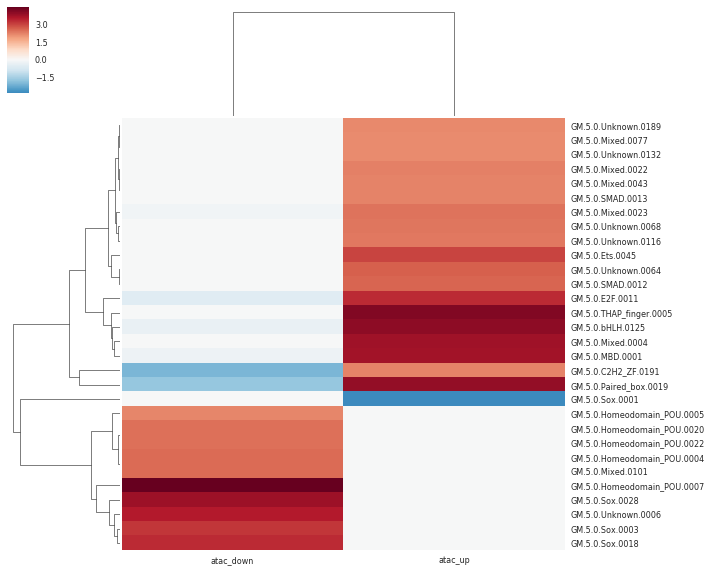

In [8]:
### IMPORT RESULTS FOR DYNAMIC ATAC REGIONS ###

res_1_a = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_enh/final.out.csv", index_col=0)

res_enh_down = np.mean(np.array([res_1_a["atacDown"].values]),axis=0)
res_enh_up = np.mean(np.array([res_1_a["atacUP"].values]),axis=0)


res_a = pd.DataFrame({"atac_down":res_enh_down, "atac_up":res_enh_up}, index=res_1.index)
res_a[np.any(abs(res_a) >= 2, 1)]
sns.clustermap(res_a[["atac_down","atac_up"]][np.any(abs(res_a[["atac_down","atac_up"]]) >= 2, 1)],cmap="RdBu_r",center=0)
# res_a[["atac_down","atac_up"]][np.any(res_a[["atac_down","atac_up"]] >= 2, 1)]



,up,down,atac_up,atac_down
GM.5.0.Mixed.0101,0.000000,0.942962,0.000000,2.517178
GM.5.0.Homeodomain_POU.0005,0.000000,0.009507,0.000000,2.135433
GM.5.0.Homeodomain_POU.0004,0.000000,0.082349,0.000000,2.502928
GM.5.0.Homeodomain_POU.0020,-0.027370,0.000000,0.000000,2.431238
GM.5.0.Homeodomain_POU.0022,0.000000,0.000000,0.000000,2.417315
...,...,...,...,...
GM.5.0.THAP_finger.0005,-0.221283,0.000000,4.070573,0.000000
GM.5.0.Mixed.0004,0.000000,0.000000,3.713981,0.000000
GM.5.0.bHLH.0125,0.000000,0.000000,3.953079,-0.332733
GM.5.0.C2H2_ZF.0191,-0.005338,0.000000,2.183720,-2.014486


<Figure size 2400x1600 with 0 Axes>

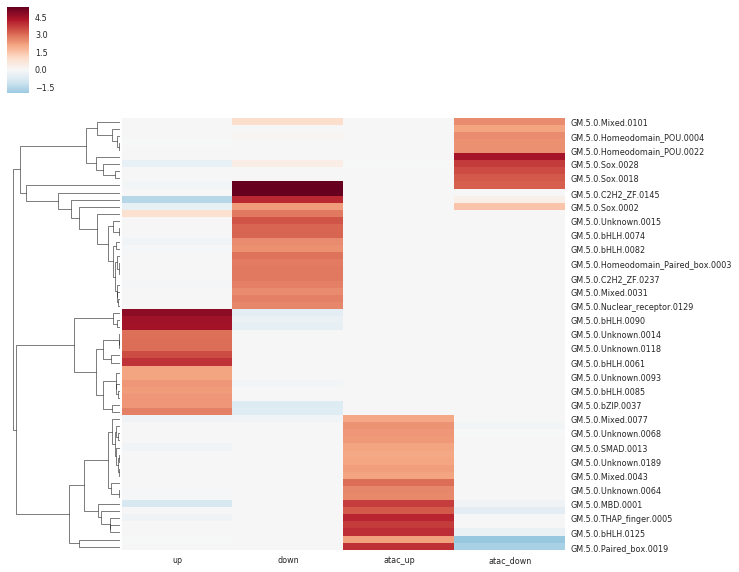

In [9]:
### COMBINE ATAC ON PROMOTERS AND DYNAMIC ATAC TO CREATE REFERECE DATAFRAME ###

res_fin = res_.merge(res_a, how='right', right_index=True, left_index=True)
res_fin = res_fin[["up","down","atac_up","atac_down"]]
plt.figure(dpi=400)
ccc = sns.clustermap(res_fin[np.any(res_fin >= 2, 1)],cmap="RdBu_r",center=0, col_cluster=False)
ccc.data2d #res_fin[np.any(res_fin >= 2, 1)]



/package/anaconda3/bin/ipython:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 12000x6000 with 0 Axes>

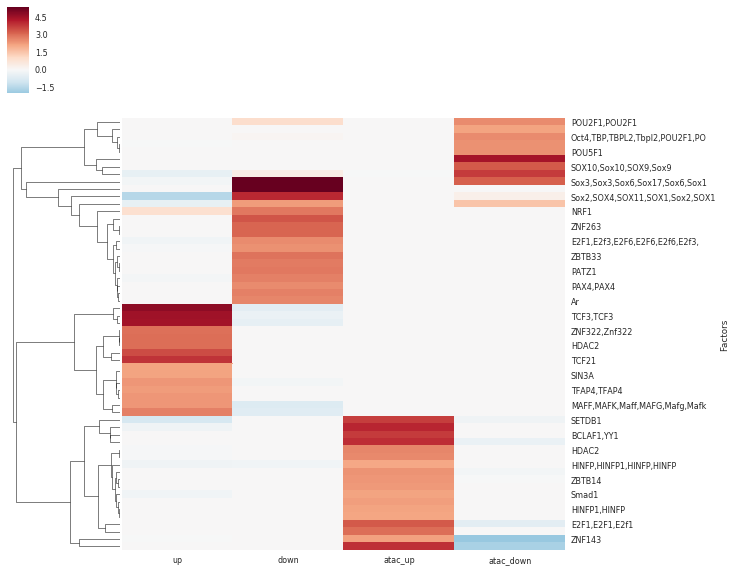

In [10]:
### TRANSLATE MOTIF IDS TO PUTATIVE TRANSCRIPTION FACTORS ###

m2f = pd.read_table("../INTERMEDIATE_FILES/Maelstrom_ATAC_DEG_1/gimme.vertebrate.v5.0.motif2factors.txt", index_col=0)
m2f_ = [",".join(m2f.groupby("Motif").get_group(j)['Factor'].values) for j in m2f.index.unique()]
m2f = pd.Series(m2f_, name="Factors", index = m2f.index.unique()).to_frame()
m2f.Factors = m2f.Factors.str.slice(0,30)

df = res_fin.merge(m2f, right_index=True, left_index=True).set_index("Factors")
df = df[["up","down","atac_up","atac_down"]]
#df[["down","up"]][np.any(abs(df[["down","up"]]) >= 2, 1)]
plt.figure(dpi=400, figsize=(30,15))
cm = sns.clustermap(df[np.any(df >= 2, 1)],cmap="RdBu_r",center=0, col_cluster=False)
# cm.fig.subplots_adjust(right=0.5)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()

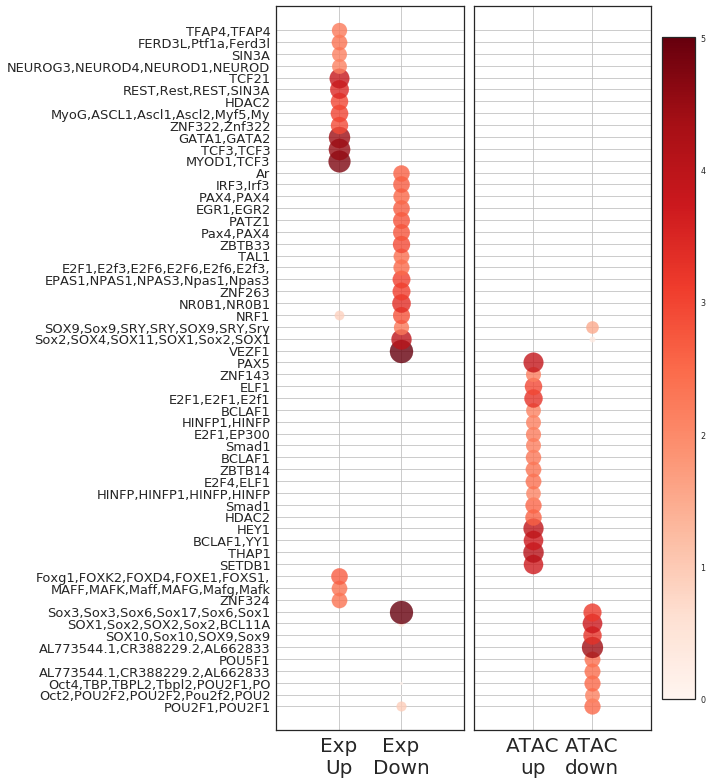

In [18]:
### PLOT RESULTS AND SAVE ###

data = cm.data2d[np.any(cm.data2d >= 2, 1)]
data["factors"] = data.index
data.index = range(data.shape[0])
data = data.reindex(labels = list(data.index[:9])+list(data.index[37:])+list(data.index[9:37]), axis=0)
data.index = data["factors"]
data.drop(["factors"],axis='columns', inplace=True)
data

fig,ax = plt.subplots(1,2, figsize=(10,11), gridspec_kw = {'width_ratios':[1.7, 2]})
ax[0].grid(color="silver")

ax[0].set_xticks(range(2))
ax[0].set_xticklabels(["Exp\nUp","Exp\nDown"],size=20)

ax[0].set_yticks(range(data.shape[0]))
ax[0].set_yticklabels(data.index, size=13)
ax[0].set_xlim(-1,2)
ax[0].set_ylim(-2,data.shape[0]+1)
norm = mcolors.Normalize(vmin=0, vmax=5, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
col_map = pd.DataFrame()
col_map['up'] = data['up'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
col_map['down'] = data['down'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
col_map['atac_up'] = data['atac_up'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
col_map['atac_down'] = data['atac_down'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))


# col_map
for i in range(2):
    for j in range(data.shape[0]):
        if data.values[j,i] > 0:
            ax[0].scatter([i], [j], s=np.fabs(data.values[j,i])*100, color = col_map.values[j,i], zorder=3,alpha=0.8)
plt.tight_layout()   



ax[1].grid(color="silver")

ax[1].set_xticks(range(2))
ax[1].set_xticklabels(["ATAC\nup","ATAC\ndown"],size=20)

ax[1].set_yticks(range(data.shape[0]))
ax[1].set_yticklabels([], size=13)
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-2,data.shape[0]+1)


# col_map
for i in range(2):
    for j in range(cm.data2d[["atac_up","atac_down"]].shape[0]):
        if data[["atac_up","atac_down"]].values[j,i] > 0:
            ax[1].scatter([i], [j], s=np.fabs(data[["atac_up","atac_down"]].values[j,i])*100, color = col_map[["atac_up","atac_down"]].values[j,i], zorder=3,alpha=0.8)
cbar=plt.colorbar(mapper)
plt.tight_layout()   

#"ATAC\nup","ATAC\ndown"
plt.savefig("../FIGURES/Maelstrom_promoters_enhancers.pdf")